<a href="https://colab.research.google.com/github/nawinaswin/ML1/blob/main/OpenAI_CartPole_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
 
# install required system dependencies
apt-get install -y xvfb x11-utils

In [ ]:
# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import torch
import torch as pt
import gym as gym
import random as rd
import math as math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision as tv
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display

In [ ]:
import pyvirtualdisplay

In [ ]:
_display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)) 
_ = _display.start()

In [ ]:
print(torch.cuda.get_device_name())
!echo $DISPLAY

Tesla T4



In [ ]:
class DQN(pt.nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = pt.nn.Linear(in_features=img_height * img_width * 3, out_features=24)
        self.fc2 = pt.nn.Linear(in_features=24, out_features=32)
        self.fc3 = pt.nn.Linear(in_features=32, out_features=32)
        self.out = pt.nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = self.out(t)
        return t


Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.push_count = 0
        self.memory = []

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return rd.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size


class Epsilon:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1 * current_step * self.decay)


# strategy = Epsilon()


class Agent():
    def __init__(self, strategy, number_of_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.number_of_actions = number_of_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > rd.random():
            action = rd.randrange(self.number_of_actions)  # explore
            #print(torch.tensor([action]).to(device))
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                #print(policy_net(state).argmax(dim=1).to(device))
                return policy_net(state).argmax(dim=1).to(device)  # exploit


class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, blank1, blank2 = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        resize = T.Compose([T.ToPILImage(), T.Resize((40, 90)), T.ToTensor()])

        return resize(screen).unsqueeze(0).to(self.device)
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [ ]:
def plot(values, moving_average_period):
        plt.figure(2)
        plt.clf()
        plt.title("Training.....")
        plt.xlabel("Episodes")
        plt.ylabel("Duration")
        plt.plot(values)
        ma = get_moving_average(values, moving_average_period)
        plt.plot(ma)
        plt.pause(0.001)
        print("Episode:", len(values),", Moving Average:", ma[-1] )
        display.clear_output(wait=True)


def get_moving_average(values, period):
        values = torch.tensor(values, dtype=torch.float)
        if len(values) >= period:
            moving_average = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
            moving_average = torch.cat((torch.zeros(period - 1), moving_average))
            return moving_average.numpy()
        else:
            moving_average = torch.zeros(len(values))
            return moving_average.numpy()

def extract_tensors():
        batch = Experience(*zip(*expriences))
        t1 = torch.cat(batch.state)
        t2 = torch.cat(batch.action)
        t3 = torch.cat(batch.reward)
        t4 = torch.cat(batch.next_state)
        return t1, t2, t3, t4

def plot_screen_dynamic(screen):
  plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
  plt.title('Non starting state example')
  plt.show()
  display.clear_output(wait=True)

In [ ]:
batch_size = 256
gamma = 0.999
eps_start = 0.9
eps_end = 0.05
eps_decay = 200
target_update = 10
memory_size = 10000
lr = 0.001
num_episodes = 250

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


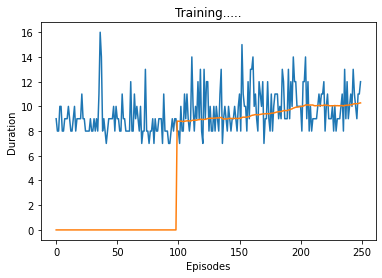

Episode: 250 , Moving Average: 10.28


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CartPoleEnvManager(device)
strategy = Epsilon(eps_start, eps_end, eps_decay)
agent = Agent(strategy, env.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(env.get_screen_height(), env.get_screen_width()).to(device)
target_net = DQN(env.get_screen_height(), env.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    env.reset()
    state = env.get_state()
    #plot_screen_dynamic(state)
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = env.take_action(action)
        next_state = env.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            expriences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors()

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if env.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()


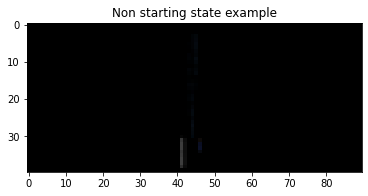

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()

for i in range(4):
    em.take_action(torch.tensor([1]))
    screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

In [ ]:
env = CartPoleEnvManager(device)
env.num_actions_available()
_, reward, done, x, y = env.env.step(action.item())
env.take_action(action)

In [ ]:
def get_moving_average(values, period):
  values = torch.tensor(values, dtype=torch.float)
  if len(values) >= period:
    moving_average = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
    moving_average = torch.cat((torch.zeros(period-1), moving_average))
    return moving_average.numpy()
  else:
    moving_average = torch.zeros(len(values))
    return moving_average.numpy()